<a href="https://colab.research.google.com/github/sangeetajay/Springboard/blob/master/3_AH_pre_processing_grayscale_Sangeeta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Capstone Project:
## Predicting House Prices from Zillow Images


## Pre-Processing/Modeling Notebook 3:





#### imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns 
%matplotlib inline

import PIL
import PIL.Image

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage.io import imread
from skimage.transform import resize
import math
from IPython.display import display
from skimage import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

#### installs

In [2]:
#!pip install -q tensorflow==2.1
#!pip install -q keras==2.3.1
#!pip install -q tensorflow-estimator==2.1.
#!pip install gast==0.3.2
#!pip install tensorflow

### Load the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# load the cleaned dataset with image name and price
# these are the 'labels' for the images
file = '/content/drive/MyDrive/cleaned_AH_data_v2.csv'
train_labels = pd.read_csv(file)
# remove the .jpg from the image names
train_labels['Image Name'] = train_labels['Image Name'].str.rstrip('.jpg')
#check the shape
print(train_labels.shape)

train_labels.head()

(15012, 2)


,Image Name,Price
0,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f,305000
1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f,295000
2,2084491383_a2ad649e1a7a098111dcea084a11c855-p_f,256125
3,120901374_b469367a619da85b1f5ceb69b675d88e-p_f,240000
4,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f,239900


#### Unzipping the images from google drive

In [5]:
!unzip /content/drive/MyDrive/ResizedGrayImages.zip

Archive:  /content/drive/MyDrive/ResizedGrayImages.zip
replace ResizedGrayImages/70342475_47ba545f8d30d79930ead321dcbf11cf-p_f.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Function to get a image:



In [6]:

#Write function to get a specific image

def load_pic(file_name, fig_type='jpg'):

    img_path = ('/content/ResizedGrayImages/{}').format(file_name)
    img = io.imread(img_path)
    #normalize the image by dividing each pixel by 255
    img = img/255
    return np.reshape(img,[250,300,1])

In [7]:
#testing the above 'load_image- function

image = load_pic('110538801_b74a3118da9370a14aa8a5e96d93c27c-p_f.jpg')

#plt.imshow(image)
print(image.shape)
print(image)

(250, 300, 1)
[[[0.45882353]
  [0.7254902 ]
  [0.65098039]
  ...
  [0.4       ]
  [0.4       ]
  [0.4       ]]

 [[0.58431373]
  [0.54901961]
  [0.43529412]
  ...
  [0.4       ]
  [0.4       ]
  [0.4       ]]

 [[0.51764706]
  [0.3372549 ]
  [0.28627451]
  ...
  [0.4       ]
  [0.4       ]
  [0.4       ]]

 ...

 [[0.72941176]
  [0.76078431]
  [0.74509804]
  ...
  [0.84705882]
  [0.85098039]
  [0.85882353]]

 [[0.7372549 ]
  [0.70588235]
  [0.76470588]
  ...
  [0.83529412]
  [0.83921569]
  [0.84705882]]

 [[0.68235294]
  [0.61568627]
  [0.69411765]
  ...
  [0.83529412]
  [0.83921569]
  [0.84705882]]]


#### checking the number of files in the *folder*

In [8]:

APP_FOLDER = '/content/ResizedGrayImages/'
totalDir = 0
totalFiles = 0
for base, dirs, files in os.walk(APP_FOLDER):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1
totalFiles    

Searching in :  /content/ResizedGrayImages/


15172

# Preparing for Generator

In [9]:
#adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly


In [10]:
train_labels.head() # this is our dataframe of the image name and labels (price)

,Image Name,Price
0,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f,305000
1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f,295000
2,2084491383_a2ad649e1a7a098111dcea084a11c855-p_f,256125
3,120901374_b469367a619da85b1f5ceb69b675d88e-p_f,240000
4,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f,239900


##### create a lookup dictionary called labels

In [11]:
labels_df = train_labels['Price']
labels_df.index = train_labels['Image Name']

#Create a lookup dictionary containing the labels for each image sample, we will use this on our data generator object

labels = labels_df.to_dict(into=dict)

##### create a dictionary called partition with train and validation

In [12]:
#Create a dictionary called partition where you gather:

train_part = train_labels.sample(frac=0.8,random_state=200) #random state is a seed value
test_part = train_labels.drop(train_part.index)

partition = {}

# in partition['train'] a list of training IDs
partition['train'] = list(train_part['Image Name'])

# in partition['validation'] a list of validation IDs
partition['validation'] = list(test_part['Image Name'])



In [28]:
# checking what we did: created a test set and a validation set 
print(type(partition['train']))
print(type(partition['validation']))
print(len(partition['train']))
print(len(partition['validation']))


<class 'list'>
<class 'list'>
12010
3002


# Generator

#### impors for generator

In [14]:
tf.__version__

'2.6.0'

#### actual start of generator

In [15]:
# First, let's write the initialization function of the class

class DataGenerator(Sequence):

  def __init__(self, list_IDs, labels, batch_size=128, dim=(250,300), n_channels=1,
              shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    #self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()


  def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

  def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = list(np.empty((self.batch_size)))
        #print(X.shape, X.dtype)
        #print(y.shape, y.dtype)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            #X[i,] = load_pic(ID, size=self.dim[0], n_channels=self.n_channels)
            try:
              X[i,] = load_pic(ID+'.jpg' )
              
            #print(X[i,])

            # Store class
              y[i] = self.labels[ID]
            except:
              continue
              
        #print(type(X), type(y))
        #print(y)
        return X, np.array(y)



In [16]:
# Parameters
params = {'dim': (250,300),
          'batch_size': 128,
          'n_channels': 1,
          'shuffle': True}

# Import the EarlyStopping and ModelCheckpoint callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Define a callback to monitor validation accuracy
monitor_val_loss = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Generators

#def get_train_images():
training_generator = DataGenerator(partition['train'], labels, **params)

#def get_validation_images():
validation_generator = DataGenerator(partition['validation'], labels, **params)


In [17]:
a = DataGenerator(partition['train'], labels, **params)
a

## Metric Function

In [18]:
# from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/

from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


## CNN model 
from https://www.linkedin.com/learning/neural-networks-and-convolutional-neural-networks-essential-training/creating-and-compiling-the-model?u=36492188
for images

In [19]:
# CNN model
from tensorflow.keras import Sequential

cnn2 = Sequential()
cnn2.add(Conv2D(32, kernel_size=(3,3), input_shape=(250,300,1),padding='same', activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Flatten())
cnn2.add(Dropout(0.5))
cnn2.add(Dense(512, activation='relu'))
cnn2.add(Dense(32, activation='relu'))
cnn2.add(Dense(1, activation='linear'))
cnn2.compile(optimizer='adam', loss='mean_absolute_error', metrics=[[coeff_determination, 'mae']])


In [20]:
print(cnn2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 300, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 37, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 37, 128)       1

In [21]:
history = cnn2.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs = 40, steps_per_epoch=200, callbacks=[monitor_val_loss],
                    use_multiprocessing=True,)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
200/200 [==============================] - 90s 410ms/step - loss: 242097.4219 - coeff_determination: -0.2354 - mae: 242097.4219 - val_loss: 211777.7031 - val_coeff_determination: -0.1094 - val_mae: 211777.7031
Epoch 2/40
200/200 [==============================] - 80s 396ms/step - loss: 212882.4844 - coeff_determination: -0.0493 - mae: 212882.4844 - val_loss: 206424.5156 - val_coeff_determination: -0.0226 - val_mae: 206424.5156
Epoch 3/40
200/200 [==============================] - 81s 401ms/step - loss: 210234.1250 - coeff_determination: -0.0345 - mae: 210234.1250 - val_loss: 205633.7188 - val_coeff_determination: -0.0061 - val_mae: 205633.7188
Epoch 4/40
200/200 [==============================] - 81s 404ms/step - loss: 360287962136576.0000 - coeff_determination: -0.0333 - mae: 360287962136576.0000 - val_loss: 205899.0938 - val_coeff_determination: -0.0442 - val_mae: 205899.0938
Epoch 5/40
200/200 [==============================] - 82s 409ms/step - loss: 209684.0625 - coeff_d

In [22]:
def plot_loss(coeff_determination,val_coeff_determination):
    """Plots loss as a function of epoch for validation 
           and training sets"""
    
    plt.figure()
    plt.plot(coeff_determination)
    plt.plot(val_coeff_determination)
    plt.title('Coefficient of Determination')
    plt.ylabel('R-squared')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

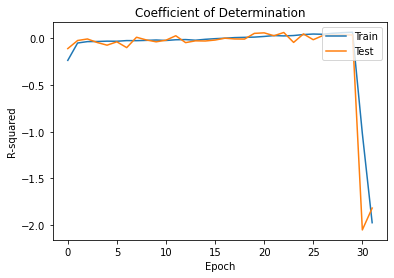

In [23]:
# Plot train vs test loss during training
plot_loss(history.history['coeff_determination'], history.history['val_coeff_determination'])

In [24]:
def plot_loss(mae,val_mae):
    """Plots loss as a function of epoch for validation 
           and training sets"""
    
    plt.figure()
    plt.plot(mae)
    plt.plot(val_mae)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

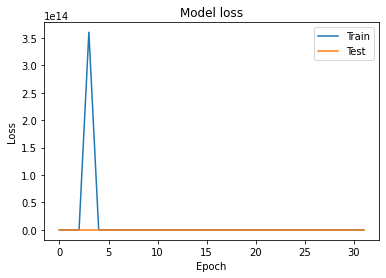

In [25]:

# Plot train vs test loss during training
plot_loss(history.history['mae'], history.history['val_mae'])

## Visualize the filters
from : https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [26]:
# summarize filter shapes
for layer in cnn2.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

#output is the name of the layer and the shape of the filter

conv2d (3, 3, 1, 32)
conv2d_1 (3, 3, 32, 64)
conv2d_2 (3, 3, 64, 128)
conv2d_3 (3, 3, 128, 128)


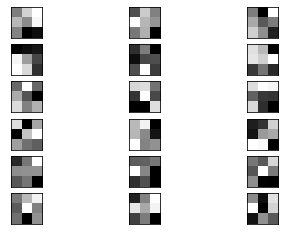

In [27]:

# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()